In [15]:
import numpy as np                                # For numerical operations and handling arrays
import pandas as pd                               # For data manipulation and analysis
import seaborn as sns                             # For statistical data visualization (e.g., heatmaps)
import matplotlib.pyplot as plt                   # For visualizing data
from sklearn.preprocessing import MinMaxScaler    # For scaling the data (Min-Max)
from sklearn.preprocessing import StandardScaler  # For scaling the data (Standardization)
from sklearn.cluster import KMeans                # For K-Means clustering
from sklearn.cluster import DBSCAN                # For DBSCAN clustering
from sklearn.metrics import silhouette_score      # For evaluating clustering performance
from sklearn.manifold import TSNE                 # For dimensionality reduction (t-SNE)
from sklearn.decomposition import PCA
import os                                         # For Traversing through directories to find and access files (useful for Kaggle Kernels)
import warnings


# Ignore all warnings
warnings.filterwarnings('ignore')

In [26]:
customer_data = pd.read_csv('.\data\OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [29]:
customer_data['InvoiceDate'] = pd.to_datetime(customer_data['InvoiceDate'], format='%d-%m-%Y %H:%M')



In [37]:
# Creating Total_Price column
customer_data['Total_Price'] = customer_data['Quantity'] * customer_data['UnitPrice']

# Reference date for recency calculation
reference_date = customer_data['InvoiceDate'].max()

# Creating new DataFrame, grouping by CustomerID and calculating RFM metrics
customer_data_rfm = customer_data.groupby('CustomerID').agg({
    # Calculate Recency as the number of days since the most recent purchase for each customer
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)

    # Count the number of invoices for each customer to calculate Frequency
    'InvoiceNo': 'count',                                      # Frequency (number of transactions)

    # Calculate the total spending of each customer by summing the 'Total_Price'
    'Total_Price': 'sum'                                       # Monetary (total money spent)
})

# Rename columns for clarity
customer_data_rfm = customer_data_rfm.rename(columns={
    'InvoiceDate': 'Recency',      # Renaming InvoiceDate column as Recency
    'InvoiceNo': 'Frequency',      # Renaming InvoiceNo column as Frequency
    'Total_Price': 'Monetary'      # Renaming Total_Price column as Monetary
}).reset_index()

# Saving preprocessed dataset
customer_data_rfm.to_csv('customer_data_rfm.csv', index=False)

# Display the first few rows of the RFM DataFrame
customer_data_rfm.head(20)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
5,12352.0,35,95,1545.41
6,12353.0,203,4,89.00
7,12354.0,231,58,1079.40
8,12355.0,213,13,459.40
9,12356.0,22,59,2811.43


In [31]:
# Normalizing RFM data using Min-Max Scaling
scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data_rfm[['Recency', 'Frequency', 'Monetary']])

# Create a new DataFrame for the scaled features
customer_data_normalized = pd.DataFrame(customer_data_scaled, columns= ['Recency','Frequency','Monetary'])

# Combine the normalized features with the CustomerID
customer_data_normalized = pd.concat([customer_data_rfm[['CustomerID']].reset_index(drop=True), customer_data_normalized], axis=1)

# Saving Normalized dataset
customer_data_normalized.to_csv('customer_data_normalized.csv', index=False)  # After scaling

# Displaying the RFM DataFrame
print("RFM DataFrame before scaling the data:")
print(customer_data_rfm.head())

# Displaying the normalized RFM DataFrame
print("\nNormalized RFM DataFrame after scaling the data:")
print(customer_data_normalized.head())

RFM DataFrame before scaling the data:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1        182   4310.00
2     12348.0       74         31   1797.24
3     12349.0       18         73   1757.55
4     12350.0      309         17    334.40

Normalized RFM DataFrame after scaling the data:
   CustomerID   Recency  Frequency  Monetary
0     12346.0  0.871314   0.000125  0.015109
1     12347.0  0.002681   0.022676  0.030297
2     12348.0  0.198391   0.003758  0.021442
3     12349.0  0.048257   0.009020  0.021303
4     12350.0  0.828418   0.002005  0.016288


Applying Clustering Algorithms¶
K-Means Clustering
First, we apply K-Means Clustering to segment customers based on the RFM metrics.

In [66]:
# Applying K-Means with the optimal number of clusters
optimal_k = 5  # Example based on analysis (adjust based on your results)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data_rfm['K_Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Inspect clusters
print(customer_data_rfm.groupby('K_Cluster').mean())

             CustomerID     Recency   Frequency     Monetary  DB_Cluster
K_Cluster                                                               
0          15302.717258   16.838298  147.959811  3143.084355         0.0
1          15374.239216  159.613725   40.425490   643.322059         0.0
2          15336.033333  335.730000   22.956667   327.978233         0.0
3          15236.923228   72.601378   54.781496   998.622108         0.0
4          15319.160093  247.238979   24.900232   490.381951         0.0


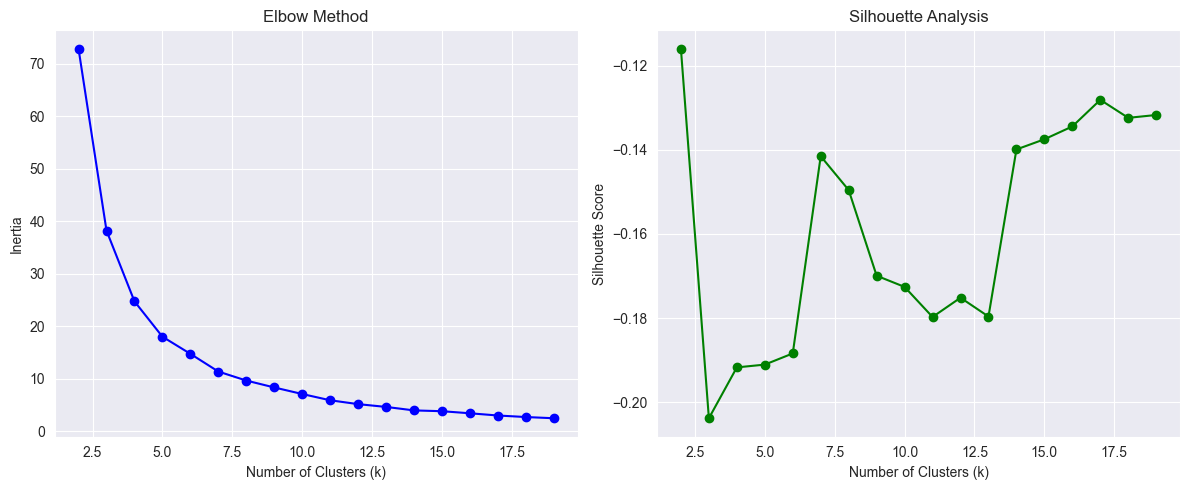

In [42]:
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 20)

for n in K:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_data_rfm, kmeans.labels_))

# Plot Elbow Method
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [68]:
# Saving clusters output dataset
customer_data_rfm.to_csv('customer_data_rfm.csv', index=False)

# Sample output of clusters
print("Custers Output:")
print(customer_data_rfm.head(10))

Custers Output:
   CustomerID  Recency  Frequency  Monetary  DB_Cluster  K_Cluster
0     12346.0      325          2      0.00           0          2
1     12347.0        1        182   4310.00           0          0
2     12348.0       74         31   1797.24           0          3
3     12349.0       18         73   1757.55           0          0
4     12350.0      309         17    334.40           0          2
5     12352.0       35         95   1545.41           0          0
6     12353.0      203          4     89.00           0          1
7     12354.0      231         58   1079.40           0          4
8     12355.0      213         13    459.40           0          4
9     12356.0       22         59   2811.43           0          0


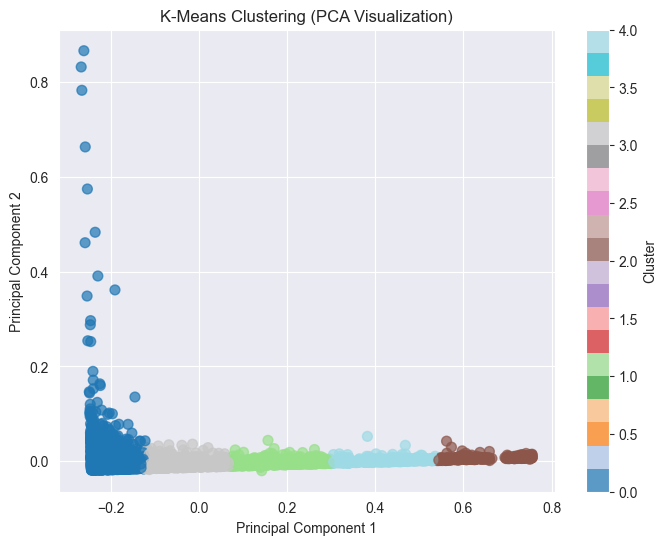

In [64]:
# Applying PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(customer_data_scaled)
map = "tab20"

# Plot for K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_data_rfm['K_Cluster'], cmap = map, s=50, alpha=0.7)
plt.title('K-Means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()



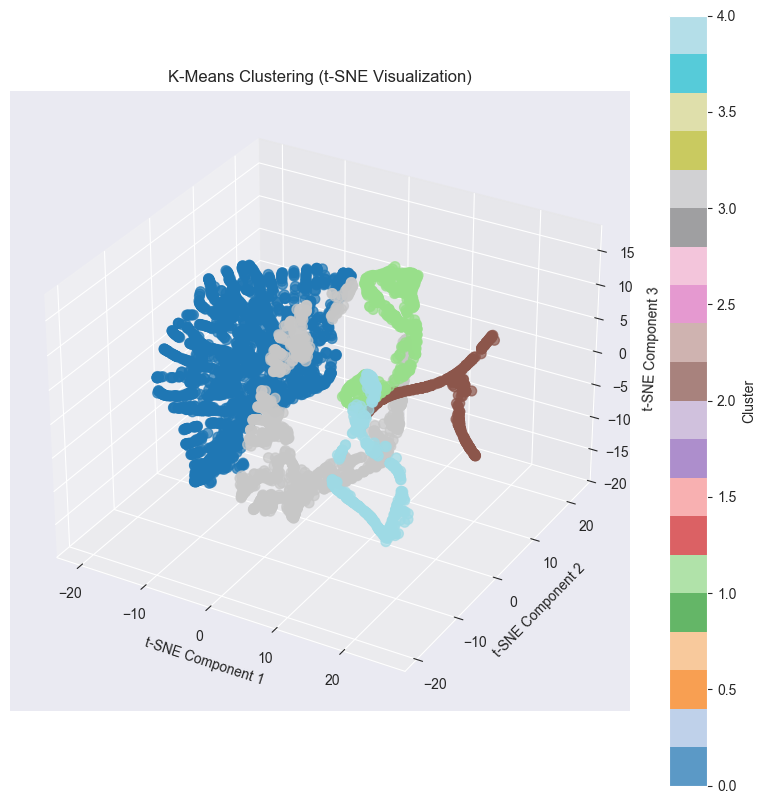

In [65]:
# Applying t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(customer_data_scaled)

# 3D Scatter Plot For K-Means
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=customer_data_rfm['K_Cluster'], cmap = map, s=50, alpha=0.7)
ax.set_title('K-Means Clustering (t-SNE Visualization)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.colorbar(scatter, label='Cluster')
plt.show()



In [58]:
# Obținerea datelor pentru fiecare cluster
cluster_summary = customer_data_rfm.groupby('K_Cluster').mean()

# Afișarea detaliilor fiecărui cluster
print(cluster_summary)


             CustomerID     Recency   Frequency     Monetary  DB_Cluster
K_Cluster                                                               
0          15302.717258   16.838298  147.959811  3143.084355         0.0
1          15374.239216  159.613725   40.425490   643.322059         0.0
2          15336.033333  335.730000   22.956667   327.978233         0.0
3          15236.923228   72.601378   54.781496   998.622108         0.0
4          15319.160093  247.238979   24.900232   490.381951         0.0


In [78]:
import plotly.express as px
import pandas as pd

# Convert data into a DataFrame for easier plotting
data_3d = pd.DataFrame({
    'Component 1': X_tsne[:, 0],
    'Component 2': X_tsne[:, 1],
    'Component 3': X_tsne[:, 2],
    'Cluster': customer_data_rfm['K_Cluster']
})

# Create an interactive 3D scatter plot with a better theme
fig = px.scatter_3d(
    data_3d,
    x='Component 1',
    y='Component 2',
    z='Component 3',
    color='Cluster',
    title="Enhanced t-SNE 3D Visualization of K-Means Clusters",
    opacity=0.8
)

# Customize the layout and background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='t-SNE Component 1'),
        yaxis=dict(title='t-SNE Component 2'),
        zaxis=dict(title='t-SNE Component 3'),
        bgcolor='rgba(30,30,30,1)'  # Darker background for better contrast
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    title=dict(font=dict(size=20)),
    legend=dict(itemsizing='constant')
)
fig.update_traces(marker=dict(size=6))  # Make the points larger and clearer
fig.show()
